In [1]:
import os
import time
import json

from utils.file_utils import *
from datasets import list_datasets
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from IPython import get_ipython
import pandas as pd
from tqdm import tqdm
from models.MergeModel import MergeModel
from models.ClassifierModel import ClassifierModel
from transformers import BartTokenizer, BartForConditionalGeneration, BartForSequenceClassification
import matplotlib.pyplot as plt

get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', 2)

In [2]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

In [3]:
vocab_size = tokenizer.vocab_size
vocab_size

50265

In [4]:
df = pd.read_csv("dataset/test.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 11,490



,article,highlights,id
5631,Dozens of staff at Manchester United's Megasto...,Mascot among dozen of staff concerned about th...,6dd7930667c3ac55ba6ffd382a7637ba5e33e065
5879,Ahead of a weekend featuring drama from the Ba...,Reading face Arsenal at Wembley on Saturday in...,74169a8577c0e13c81559011439392fecb8fc6c3
511,"(CNN)[Breaking news update, posted at 5:22 p.m...",Military has not confirmed if any rescued girl...,777ad85a86e8e8675454e243517afa2689f81575
8859,"Bearing in mind he’s a dog, Don the border col...",The bizarre incident happened on M74 near Abin...,be8a11519f9001b83610bc1e39ef476617921054
1023,"(CNN)Saturday at the Masters, like any PGA tou...",Jordan Spieth holds lead in 2015 Masters .\nSt...,f555b81fb888354a9a83ba9acc1bdb18791441ca
8101,An Australian teenager has joined the puffy po...,Aussie girl joins #kyliejennerchallenge curren...,ac351092890e1f82ee66d97139d4aaa24f6a7131
1201,A shocking new video appearing to show at leas...,Video seems to show militants in Libya holding...,02e7ee52406518338ea1d184af26d107a3c0ab7c
9423,We’ve all been there: you hear a catchy song a...,Reading scientists say chewing gum helps you f...,cc3bc57fb6a2e29054d13933fbc5f2e0a63e3d79
3635,England suffered an injury scare at the start ...,Broad slipped in his delivery stride and was l...,3e27e82895df660541c19e828d19a68023a04034
63,"(CNN)Andrew Getty, one of the heirs to billion...",Andrew Getty's death appears to be from natura...,0d3c8c276d079c4c225f034c69aa024cdab7869d


In [5]:
train_sentence = df.article.values
train_target = df.highlights.values

In [6]:
num_data_points = 10000
train_sentence = list(train_sentence[:num_data_points])
train_target = list(train_target[:num_data_points])

In [7]:
article_encoding = tokenizer(train_sentence, return_tensors='pt', padding=True, truncation = True, max_length=500)
summary_encoding = tokenizer(train_target, return_tensors='pt', padding=True,truncation = True, max_length=100)

In [8]:
article_input_ids = article_encoding['input_ids']
article_attention_mask = article_encoding['attention_mask']

In [9]:
summary_input_ids = summary_encoding['input_ids']
summary_attention_mask = summary_encoding['attention_mask']

In [10]:
print(article_input_ids.shape, article_attention_mask.shape)

torch.Size([10000, 500]) torch.Size([10000, 500])


In [11]:
print(summary_input_ids.shape, summary_attention_mask.shape)

torch.Size([10000, 100]) torch.Size([10000, 100])


In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [13]:
batch_size = 10
train_data = TensorDataset(article_input_ids, article_attention_mask,\
                           summary_input_ids, summary_attention_mask)

In [14]:
train_sampler = RandomSampler(train_data)

In [15]:
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [16]:
def loss_fn(lm_logits, labels):
    loss_fct = CrossEntropyLoss(ignore_index = tokenizer.pad_token_id)
    loss = loss_fct(lm_logits.view(-1, vocab_size), labels.view(-1))
    return loss

In [17]:
def softmax_MSE(sentiment1, sentiment2):
    mse_loss = nn.MSELoss()    
    s1 = F.softmax(sentiment1)
    s2 = F.softmax(sentiment2)    
    return mse_loss(s1,s2)

In [18]:
sent_model = torch.load('experiment/classifier/classifier.pt')

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'ClassifierModel.ClassifierModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [19]:
sent_model

ClassifierModel(
  (embedding): Embedding_(
    (embedding): Embedding(50265, 64)
  )
  (lstm): LSTM(64, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [20]:
summary_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [21]:
summary_model = summary_model.cuda()
senti_model = sent_model.cuda()

In [22]:
# embedding_dim = 64
# out_dim = 2
# n_layers = 4
# hidden_size = 512
merge_model = MergeModel(summary_model, senti_model,freeze_sentiment=False)
model_name = 'MSE_softmax_regularized_1e-3'
model_dir = './experiment'
model_path = os.path.join(model_dir,model_name)
epochs  = 3

In [23]:
config = {
#     'embedding_dim': embedding_dim,
#     'out_dim': out_dim,
#     'n_layers': n_layers,
#     'hidden_size': hidden_size,
    'model_name': model_name,
    'epochs':epochs,
    'lambda': 1e-3
}

In [24]:
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False, model_dir='./experiment',optimizer='ADAM',config = None):
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    min_val_loss = np.inf
    
    model_name = config['model_name']
    print(f"Start training for Model {model_name}...\n")
    
    
    if not os.path.exists(os.path.join(model_dir,model_name)):
        os.mkdir(os.path.join(model_dir,model_name))
    model_path = os.path.join(model_dir,model_name)
    write_to_file_in_dir(model_path, 'config.json', config)
    
    train_log =  'train_log.txt'
    write_string_train = f"Epoch, Cross_Entropy_Loss, MSE_Loss, Total_Loss "
    log_to_file_in_dir(model_path, train_log, write_string_train)

    if evaluation:
        val_log = 'val_log.txt'
        write_string_val = f"Epoch, Val_Loss, Val_Acc"
        log_to_file_in_dir(model_path, val_log, write_string_val)
    
    if optimizer == 'ADAM':
        optimizer = torch.optim.Adam(model.parameters())
    else:    
        optimizer = torch.optim.SGD(model.parameters(),1e-3,momentum=0.9,weight_decay=0.01)
    
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        
        for step, batch in enumerate(train_dataloader):
            model.train()
            batch_counts +=1
            
            batch[0] = batch[0].cuda()
            batch[1] = batch[1].cuda()
            batch[2] = batch[2].cuda()
            batch[3] = batch[3].cuda()
            
            model.zero_grad()
            
            summary_out,*sentiments = merge_model(batch[0],batch[1], batch[2], batch[3])
        
            loss1 = loss_fn(summary_out.logits, batch[2])
            loss2 = softmax_MSE(sentiments[0], sentiments[1])

            loss = loss1 + 1e-3*loss2
            batch_loss += loss.item()
            total_loss += loss.item()
            
            train_losses.append(loss.item())

            write_string_train = f"{epoch_i}, {loss1.item()}, {loss2.item()}, {loss.item()}"
            log_to_file_in_dir(model_path, train_log, write_string_train)
            
            
            loss.backward()

            optimizer.step()

            if (step % 100 == 0 and step != 0):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

                print("-"*70)

        if ((epoch_i %20 ==0) and (epoch_i != 0)) or (epoch_i==epochs-1):
            if evaluation == True:
                val_loss, val_accuracy = evaluate(model, val_dataloader)
                val_losses.append(val_loss)
                val_accs.append(val_accuracy)
                
                write_string_val = f"{epoch_i}, {val_loss}, {val_accuracy}"
                log_to_file_in_dir(model_path, val_log, write_string_val)
                
                time_elapsed = time.time() - t0_epoch
                
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    
                    torch.save(model, os.path.join(model_path, f'{model_name}.pt'))
                    
                print(f"{epoch_i + 1:^7} | {'-':^7} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
    torch.save(model, os.path.join(model_path,f'{model_name}_final.pt'))
        
    return  train_losses, train_accs, val_losses,val_accs

In [25]:
stats = train(merge_model, train_dataloader, val_dataloader=None, epochs=epochs, evaluation=False,  config=config, optimizer='ADAM')

Start training for Model MSE_softmax_regularized_1e-3...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


   1    |   100   |  12.255563   |     -      |     -     |   56.64  
----------------------------------------------------------------------
   1    |   200   |   9.884003   |     -      |     -     |   55.85  
----------------------------------------------------------------------
   1    |   300   |   9.168384   |     -      |     -     |   55.71  
----------------------------------------------------------------------
   1    |   400   |   8.635020   |     -      |     -     |   56.04  
----------------------------------------------------------------------
   1    |   500   |   8.156194   |     -      |     -     |   55.76  
----------------------------------------------------------------------
   1    |   600   |   7.948882   |     -      |     -     |   55.89  
----------------------------------------------------------------------
   1    |   700   |   7.811362   |     -      |     -     |   55.90  
----------------------------------------------------------------------
   1    |   8

In [26]:
train_losses, train_accs, val_losses,val_accs = stats

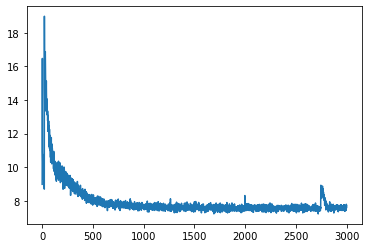

In [27]:
plt.plot(np.arange(len(train_losses)), np.array(train_losses))

b1,b2,b3,b4 = next(iter(train_dataloader))
b1 = b1.cuda()
b2 = b2.cuda()
b3 = b3.cuda()
b4 = b4.cuda()

b1.shape, b2.shape, b3.shape, b4.shape

z1 = torch.nn.Parameter(torch.ones_like(b1).float()).long()
z2 = torch.ones_like(b2)

z1_dash = z1 + 5
z2_dash = z2 + 5

t = summary_model(b1, b2)

t.logits.shape

merge_model.train()

t_dash = merge_model(b1, b2, b3,b4)

t_dash[0].logits.shape

loss = mse_loss(t_dash[1], t_dash[2])

print(torch.autograd.grad(loss,merge_model.summary_model.parameters(), retain_graph=True))